In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization
from keras.models import Model
from keras import regularizers


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
train = pd.read_json("train/processed/train.json")
#test = pd.read_json("test/processed/test.json")

In [3]:
train[:5]

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
train.shape

(1604, 5)

In [79]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

X_band_1_verticalFlip = np.zeros(X_band_1.shape)
X_band_1_horizontalFlip = np.zeros(X_band_1.shape)
X_band_1_bothFlip = np.zeros(X_band_1.shape)
X_band_2_verticalFlip = np.zeros(X_band_2.shape)
X_band_2_horizontalFlip = np.zeros(X_band_2.shape)
X_band_2_bothFlip = np.zeros(X_band_2.shape)


for imageIndex in range(X_band_1.shape[0]):
    for i in range(X_band_1.shape[1]):
        for j in range(X_band_1.shape[2]):
            X_band_1_horizontalFlip[imageIndex][i][j] = X_band_1[imageIndex][X_band_1.shape[1]-i-1][j]
            X_band_1_verticalFlip[imageIndex][i][j] = X_band_1[imageIndex][i][X_band_1.shape[2]-j-1]
            X_band_1_bothFlip[imageIndex][i][j] = X_band_1[imageIndex][X_band_1.shape[1]-i-1][X_band_1.shape[2]-j-1]

            X_band_2_horizontalFlip[imageIndex][i][j] = X_band_2[imageIndex][X_band_2.shape[1]-i-1][j]
            X_band_2_verticalFlip[imageIndex][i][j] = X_band_2[imageIndex][i][X_band_2.shape[2]-j-1]
            X_band_2_bothFlip[imageIndex][i][j] = X_band_2[imageIndex][X_band_2.shape[1]-i-1][X_band_2.shape[2]-j-1]




In [82]:
X_train_1 = np.concatenate((X_band_1, X_band_1_horizontalFlip, X_band_1_verticalFlip, X_band_1_bothFlip), axis=0)
X_train_2 = np.concatenate((X_band_2, X_band_2_horizontalFlip, X_band_2_verticalFlip, X_band_2_bothFlip), axis=0)

print(X_train_1.shape)

X_train_1 = X_train_1.reshape(X_train_1.shape[0], X_train_1.shape[1], X_train_1.shape[2], 1)
X_train_2 = X_train_2.reshape(X_train_2.shape[0], X_train_2.shape[1], X_train_2.shape[2], 1)


Y_train = train['is_iceberg']
Y_train = np.concatenate((Y_train, Y_train, Y_train, Y_train), axis=0)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

#X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
#X_train = X_band_1.reshape(X_band_1.shape[0], X_band_1.shape[1],X_band_1.shape[2], 1)


X_train = np.concatenate((X_train_1, X_train_2), axis=3)

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

(6416, 75, 75)
X_train shape: (6416, 75, 75, 2)
Y_train shape: (6416, 1)


In [83]:
print(np.max(X_train))
print(np.min(X_train))

#X_train = preprocessing.scale(X_train[:,:,:,:])

X_train = (X_train-X_train.mean(axis=(0, 1, 2), keepdims=True))/X_train.std(axis=(0, 1, 2), keepdims=True)


print(X_train.min(axis=(0, 1, 2), keepdims=True))
print(X_train.max(axis=(0, 1, 2), keepdims=True))
print(X_train.mean(axis=(0, 1, 2), keepdims=True))
print(X_train.var(axis=(0, 1, 2), keepdims=True))


34.5749168396
-45.6554985046
[[[[-4.79511521 -5.69421129]]]]
[[[[ 10.61958639  13.68714628]]]]
[[[[ -3.25626943e-14   4.05125631e-15]]]]
[[[[ 1.  1.]]]]


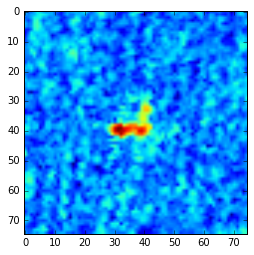

In [84]:
plt.imshow(X_band_1[1])
plt.show()

In [90]:
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
#    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0', kernel_regularizer=regularizers.l2(0.01))(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)

    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1', kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)


    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), name = 'conv2', kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool2')(X)

    
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc0', kernel_regularizer=regularizers.l2(0.01))(X)

    # FULLYCONNECTED
    X = Dense(128, activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01))(X)
    
    X = Dense(1, activation='sigmoid', name='fc2', kernel_regularizer=regularizers.l2(0.01))(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model1')

    return model

In [91]:
X_train_cv, X_valid, Y_train_cv, Y_valid = train_test_split(X_train, Y_train, random_state=1, train_size=0.80)

In [92]:
myModel = model(X_train.shape[1:])

In [93]:
myModel.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])

In [94]:
myModel.fit(x=X_train_cv, y=Y_train_cv, epochs = 10, batch_size=32)

Epoch 1/10
5132/5132 [==============================] - 122s 24ms/step - loss: 3.7271 - acc: 0.7381
Epoch 2/10
5132/5132 [==============================] - 124s 24ms/step - loss: 1.1220 - acc: 0.8451
Epoch 3/10
5132/5132 [==============================] - 124s 24ms/step - loss: 0.7585 - acc: 0.8640
Epoch 4/10
5132/5132 [==============================] - 124s 24ms/step - loss: 0.6170 - acc: 0.8761
Epoch 5/10
5132/5132 [==============================] - 546s 106ms/step - loss: 0.5552 - acc: 0.8767
Epoch 6/10
5132/5132 [==============================] - 124s 24ms/step - loss: 0.4948 - acc: 0.8887
Epoch 7/10
5132/5132 [==============================] - 126s 25ms/step - loss: 0.4614 - acc: 0.8946
Epoch 8/10
5132/5132 [==============================] - 124s 24ms/step - loss: 0.4434 - acc: 0.8922
Epoch 9/10
5132/5132 [==============================] - 123s 24ms/step - loss: 0.4184 - acc: 0.8975
Epoch 10/10
5132/5132 [==============================] - 2470s 481ms/step - loss: 0.4056 - acc: 0.9

In [14]:
pred = myModel.evaluate(x = X_valid, y = Y_valid)
### END CODE HERE ###
print()
print ("Loss = " + str(pred[0]))
print ("Test Accuracy = " + str(pred[1]))

321/321 [==============================] - 3s 8ms/step
()
Loss = 0.503228102425
Test Accuracy = 0.884735202492
